# Plausibility tests of SEAS5 data
This notebook tests if the issue with very large outliers in histograms of all datapoints of SEAS5 forecasts can be reproduced. This test is done after modifications to the code, in particular to delete encoding information read from original file before writing back to disk.
<br>

**Notes from call with Willi:**
* check values (tp) are floating point numbers, not integers
* check for implausible values in the encoding, in particular "add_offset"
* SAME scale factor or offset factor in two difffiles is a red flag!
* delete encoding: ds.tp.encoding = {}


## Question 1 Willi:
* The default value for encoding = None when calling to_netcdf(). Why do you think this may still be an issue? Why the need to manually replace the encoding dict with an empty dict?

# Part 1: Large outliers in data

In [2]:
from Dataprocessing import crop_netCDF, get_daily_tp_rate
from Download_CDS_Seasonal import download_seasonal
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tqdm import tqdm
import pandas as pd

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Step 1: Cropping and writing/reading to/from disk.
At first I load directly into memory, then use my function call to see if the issue may appear in the code of the function.

Testing for file initialised on 2003-06, as this has issues (see below).

In [24]:
ds = xr.open_dataset(r"D:\Massendaten\ECMWF\SEAS5_Global\system_5_seasonal-monthly-single-levels_2003_06_total_precipitation.nc")

In [25]:
ds.tp.encoding

{'source': 'D:\\Massendaten\\ECMWF\\SEAS5_Global\\system_5_seasonal-monthly-single-levels_2003_06_total_precipitation.nc',
 'original_shape': (215, 25, 181, 360),
 'dtype': dtype('int16'),
 'missing_value': -32767,
 '_FillValue': -32767,
 'scale_factor': 0.00010445074547365449,
 'add_offset': 3.4224331261897634}

It can be seen that the data in the initial file was compressed. Values were stored as int16 and a scale_factor and add_offset applied to convert back to float32 when reading into memory.

Now I use the function to load the dataset. At first, I do not save it to disk but directly pass it to the variable.

In [8]:
cropped = crop_netCDF(r"D:\Massendaten\ECMWF\SEAS5_Global\system_5_seasonal-monthly-single-levels_2003_06_total_precipitation.nc", 47, 55, 5, 15, to_netcdf=False)
cropped

2023-02-08 15:12:52,632 INFO 
 Trying slice with dim names 'latitude'&'longitude'


<xarray.Dataset>
Dimensions:    (longitude: 11, latitude: 9, number: 25, time: 215)
Coordinates:
  * longitude  (longitude) float32 5.0 6.0 7.0 8.0 9.0 ... 12.0 13.0 14.0 15.0
  * latitude   (latitude) float32 55.0 54.0 53.0 52.0 51.0 50.0 49.0 48.0 47.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * time       (time) datetime64[ns] 2003-06-02 2003-06-03 ... 2004-01-02
Data variables:
    tp         (time, number, latitude, longitude) float32 dask.array<chunksize=(121, 13, 9, 11), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-01-30 04:51:11 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Variable is correctly read as float32. And no encoding information is stored:

In [10]:
cropped["tp"].encoding

{}

Max value: 3.4224331378936768
Min value: 0.0


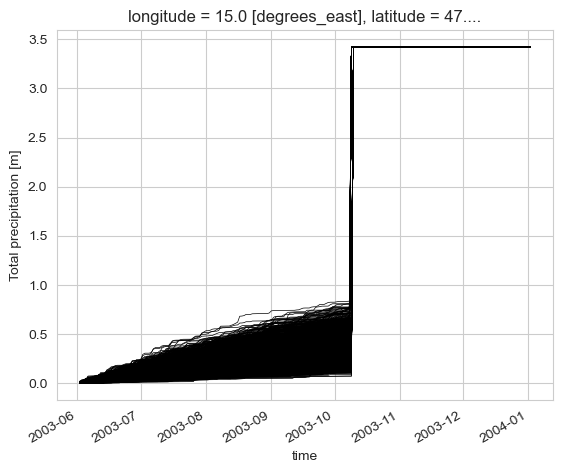

In [11]:
print(f"Max value: {cropped.tp.max().values}")
print(f"Min value: {cropped.tp.min().values}")

fig, ax = plt.subplots()
for lat in cropped.latitude.values:
     for lon in cropped.longitude.values:
         for no in cropped.number.values:
             cropped.tp.sel({"latitude":lat, "longitude":lon, "number":no}).plot(ax=ax, c='k', lw=.5)

Data looks exactly the same. Issue also in function!
<br>
I do now repeat the cropping and disaggregation for all files on disk to check how many have issues in the dataset.

In [2]:
crop_netCDF(r"D:\Massendaten\ECMWF\SEAS5_Global", 47, 55, 5, 15, to_netcdf=True, globpat="*precipitation.nc")

2023-02-08 15:16:40,623 INFO 
 Trying slice with dim names 'latitude'&'longitude'
2023-02-08 15:16:41,010 INFO Wrote file system_5_seasonal-monthly-single-levels_1994_01_total_precipitation_box.nc to disk 

2023-02-08 15:16:41,010 INFO 
 Trying slice with dim names 'latitude'&'longitude'
2023-02-08 15:16:41,118 INFO Wrote file system_5_seasonal-monthly-single-levels_1994_02_total_precipitation_box.nc to disk 

2023-02-08 15:16:41,118 INFO 
 Trying slice with dim names 'latitude'&'longitude'
2023-02-08 15:16:41,228 INFO Wrote file system_5_seasonal-monthly-single-levels_1994_03_total_precipitation_box.nc to disk 

2023-02-08 15:16:41,228 INFO 
 Trying slice with dim names 'latitude'&'longitude'
2023-02-08 15:16:41,332 INFO Wrote file system_5_seasonal-monthly-single-levels_1994_04_total_precipitation_box.nc to disk 

2023-02-08 15:16:41,332 INFO 
 Trying slice with dim names 'latitude'&'longitude'
2023-02-08 15:16:41,458 INFO Wrote file system_5_seasonal-monthly-single-levels_1994_05_to

In [3]:
get_daily_tp_rate(r"D:\Massendaten\ECMWF\SEAS5_Global\Cropped", r"D:\Massendaten\ECMWF\SEAS5_Global\Cropped\Disaggregated",globpat="*box.nc", to_netcdf=True)

2023-02-08 15:30:00,343 INFO Reading and processing 276
2023-02-08 15:30:06,225 INFO Wrote file system_5_seasonal-monthly-single-levels_1994_01_total_precipitation_box_disaggregated.nc to disk.
2023-02-08 15:30:06,272 INFO Wrote file system_5_seasonal-monthly-single-levels_1994_02_total_precipitation_box_disaggregated.nc to disk.
2023-02-08 15:30:06,335 INFO Wrote file system_5_seasonal-monthly-single-levels_1994_03_total_precipitation_box_disaggregated.nc to disk.
2023-02-08 15:30:06,384 INFO Wrote file system_5_seasonal-monthly-single-levels_1994_04_total_precipitation_box_disaggregated.nc to disk.
2023-02-08 15:30:06,445 INFO Wrote file system_5_seasonal-monthly-single-levels_1994_05_total_precipitation_box_disaggregated.nc to disk.
2023-02-08 15:30:06,492 INFO Wrote file system_5_seasonal-monthly-single-levels_1994_06_total_precipitation_box_disaggregated.nc to disk.
2023-02-08 15:30:06,555 INFO Wrote file system_5_seasonal-monthly-single-levels_1994_07_total_precipitation_box_disa

Now it is time to recalculate all the histograms to see if the error was reproduced and to conduct other plausibility checks for the data.

In [3]:
files = list(Path(r"D:\Massendaten\ECMWF\SEAS5_Global\Cropped\Disaggregated").glob("*disaggregated.nc"))

count_neg = 0
count_outlier = 0
outlier_files = []
large_neg_files = []
count_issue = 0

for file in files:
    da = xr.open_dataset(file)["tp"]
    da *= 1_000 # to get from m to mm

    if da.min().values < 0: # also check for negative tp rates
        if abs(da.min().values) > 1:
            count_issue += 1
            large_neg_files.append(file.parts[-1])
        count_neg += 1
    if da.max().values > 200:
        outlier_files.append(file.parts[-1])
        count_outlier += 1

    fig, ax = plt.subplots()
    ax.hist(da.stack(stacked_dim=[...]).values, bins=50)
    fig.savefig(file.parent / (file.parts[-1][:-3] + "_hist.png"), dpi=300)
    plt.close(fig)

print(f"\n {count_neg} files of {len(files)} have negative values \n")
print(f"{large_neg_files} \n are not small!!! -> Investigate")
print(f"\n {outlier_files} have very large values!! -> Investigate")


 276 files of 276 have negative values 

['system_5_seasonal-monthly-single-levels_2005_06_total_precipitation_box_disaggregated.nc', 'system_5_seasonal-monthly-single-levels_2010_07_total_precipitation_box_disaggregated.nc'] 
 are not small!!! -> Investigate

 [] have very large values!! -> Investigate


This looks promising, however I need to check where and why the negative values <-1mm appear. I suspect this is because of roundof errors in the initial file which cause negative values in the forward diff. Note: All files have neg tp values < .1mm (not shown). In particular this is expected when tp(t+1) < tp(t).

Only one single file still has very large values, which is promising! Let's investigate this file.

In [28]:
da_issue = xr.open_dataset(r"D:\Massendaten\ECMWF\SEAS5_Global\Cropped\Disaggregated\system_5_seasonal-monthly-single-levels_2003_06_total_precipitation_box_disaggregated.nc")["tp"]
da_issue *= 1_000
print(f"Max value {da_issue.max().values}")

Max value 3352.764404296875


In [29]:
da_issue.where(da_issue > 300, drop=True).time.values
# apparently only two timesteps are problematic

array(['2003-10-09T00:00:00.000000000', '2003-10-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

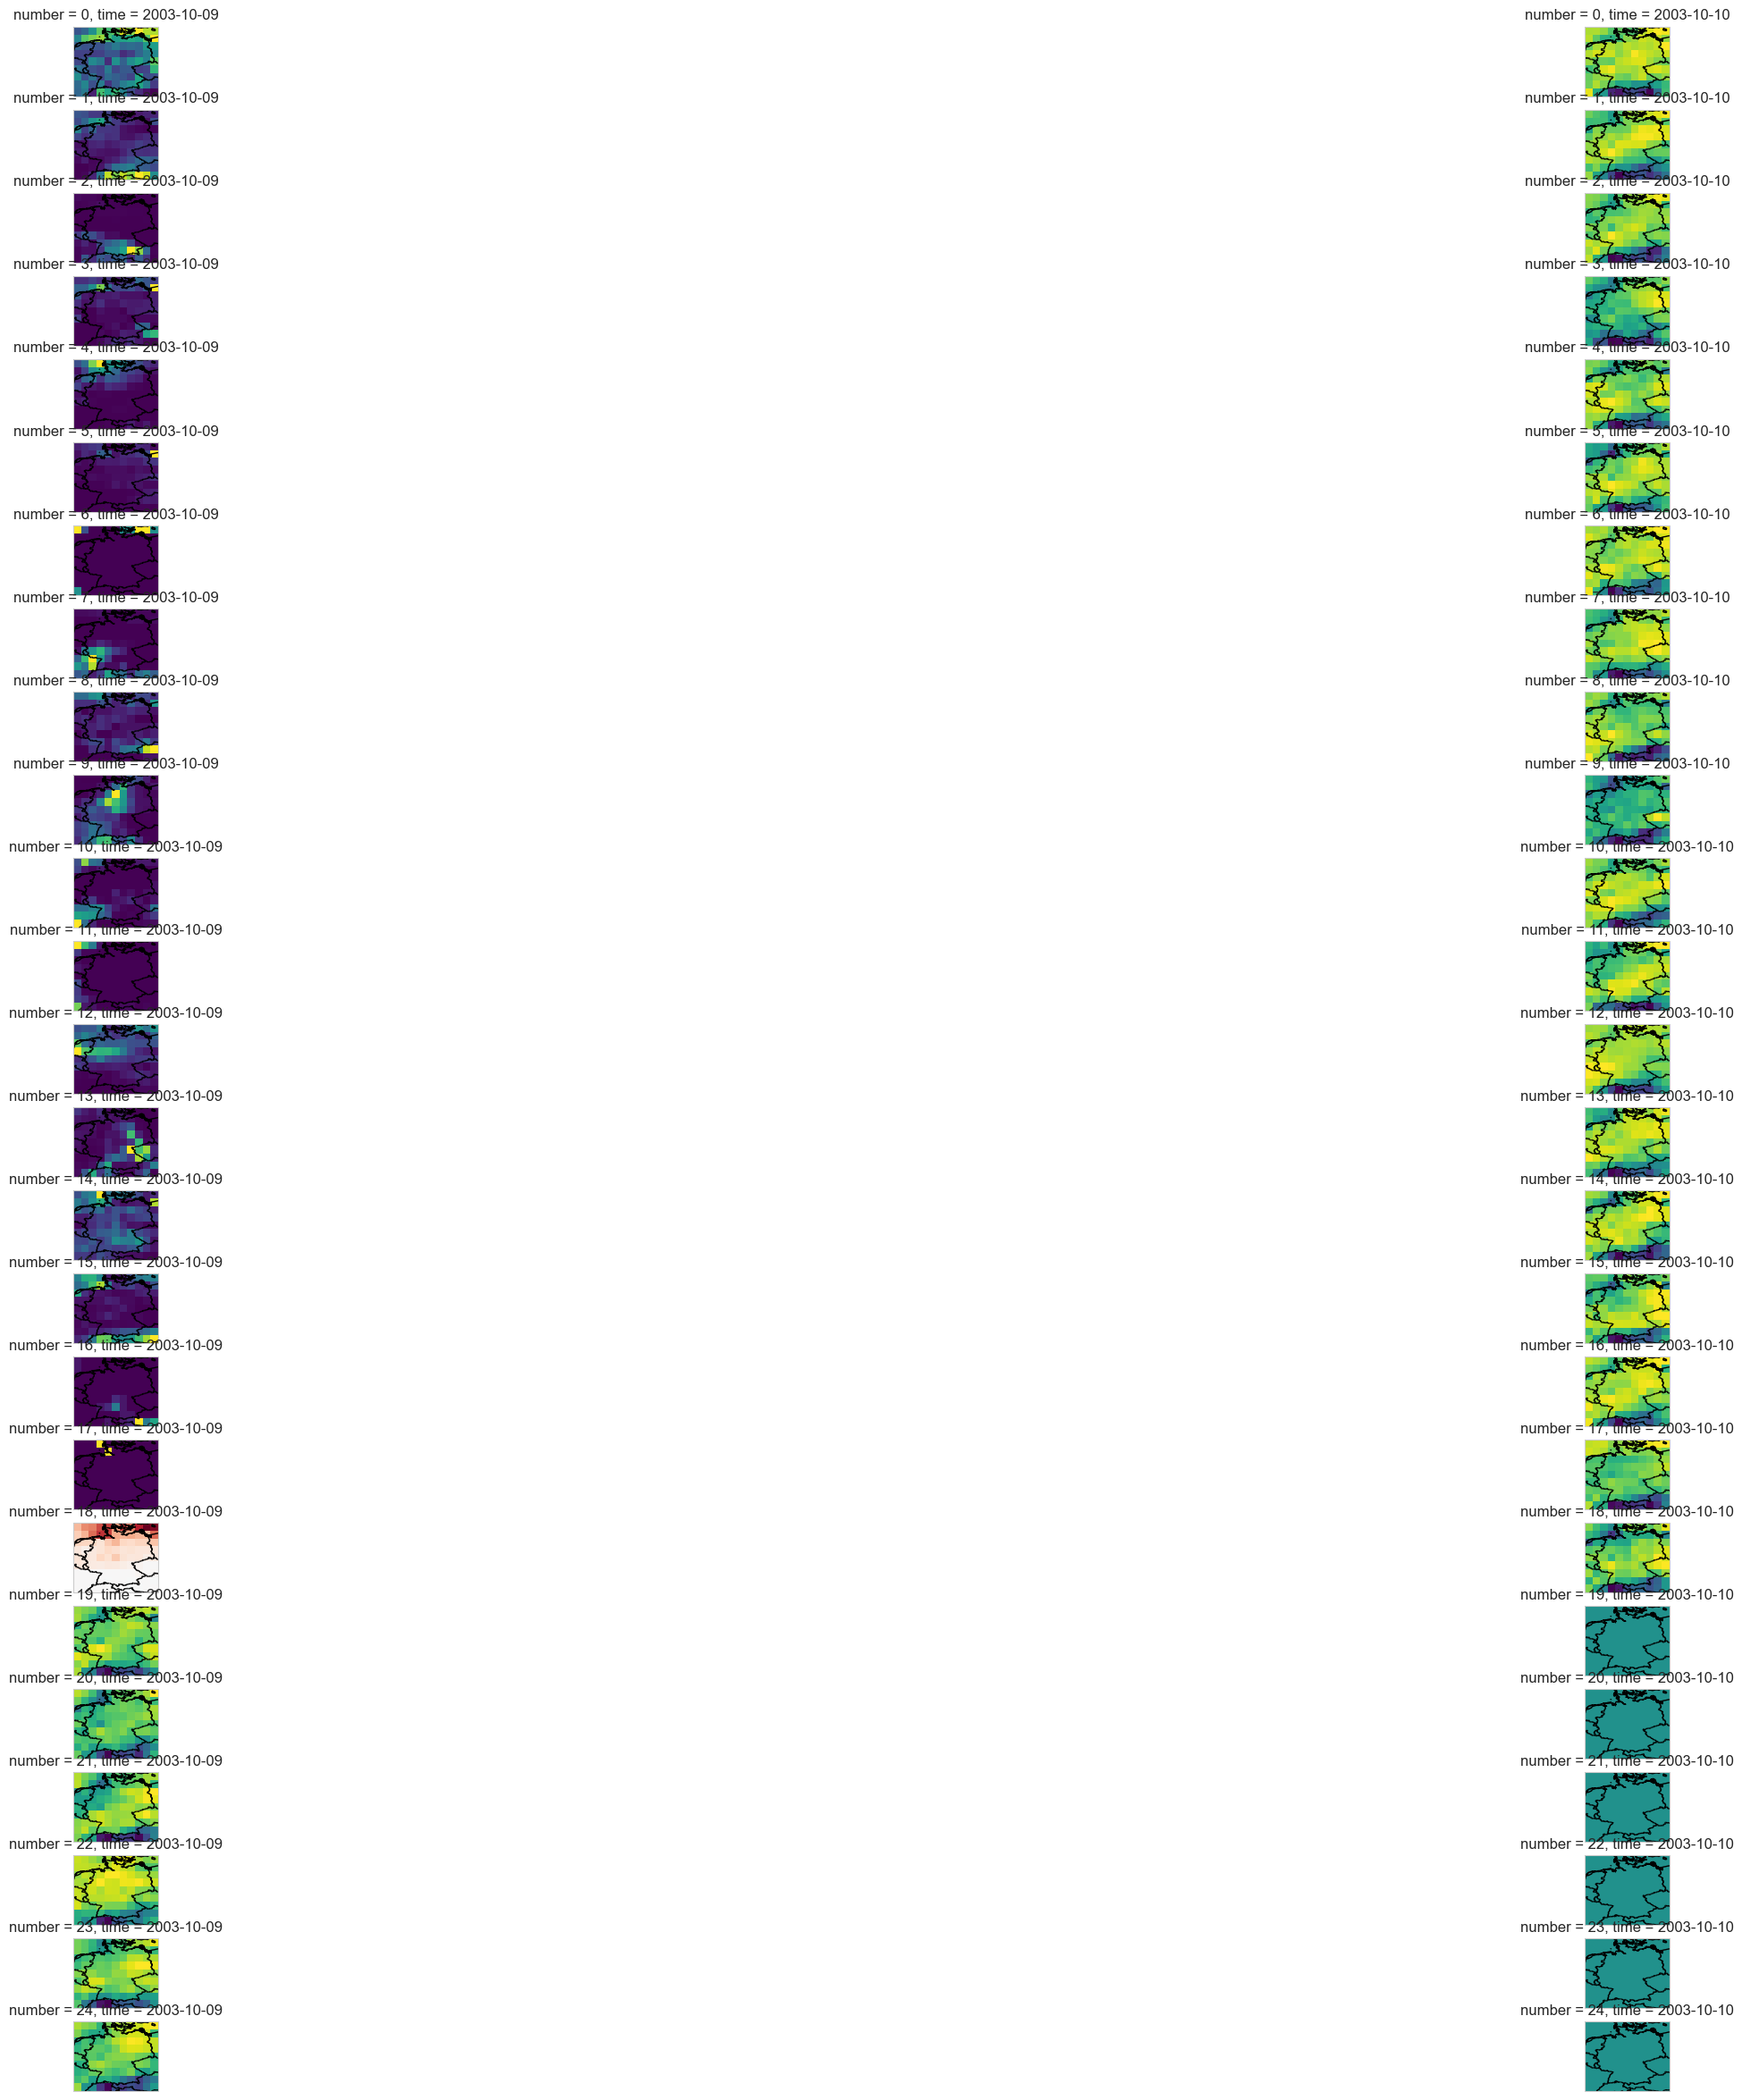

In [21]:
fig, ax = plt.subplots(subplot_kw = {"projection":ccrs.PlateCarree()}, ncols=2, nrows=25, figsize=(40,30))
for c, timestemp in enumerate(["2003-10-09", "2003-10-10"]):
    for no in da_issue.number.values:
        da_issue.sel({"time":timestemp, "number":no}).plot(ax=ax[no, c], add_colorbar=False)
        ax[no, c].add_feature(cfeature.COASTLINE)
        ax[no, c].add_feature(cfeature.BORDERS)
        ax[no, c].set(ylabel="", xlabel="")

It is funny how on 2003-10-09 the last 6 members have the jump and on day 2003-10-10 the first 19 members jump as well. Now I redownload the file to see if the issue persists:

In [2]:
# redownloading file
months = ["06"]
path = r"D:\Massendaten\ECMWF\SEAS5_Global\Issue"

download_seasonal(2003, 2003, path, months=months)

2023-02-08 11:23:52,121 INFO Checking if system_5_seasonal-monthly-single-levels_2003_06_total_precipitation.nc already exists 

2023-02-08 11:23:52,121 INFO system_5_seasonal-monthly-single-levels_2003_06_total_precipitation.nc not found, trying to download file!
2023-02-08 11:23:52,524 INFO Welcome to the CDS
2023-02-08 11:23:52,524 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-original-single-levels
2023-02-08 11:23:52,684 INFO Request is queued
2023-02-08 11:23:53,735 INFO Request is running
2023-02-08 11:24:25,173 INFO Request is completed
2023-02-08 11:24:25,182 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data2/adaptor.mars.external-1675851841.6893086-19782-8-50bb3d07-4846-4fe7-a5a5-b61d3010bf3d.nc to D:\Massendaten\ECMWF\SEAS5_Global\Issue\system_5_seasonal-monthly-single-levels_2003_06_total_precipitation.nc (668M)
2023-02-08 11:26:32,199 INFO Download rate 5.3M/s  
2023-02-08 11:26:32,603 INF

In [3]:
# Cropping
crop_netCDF(r"D:\Massendaten\ECMWF\SEAS5_Global\Issue", 47, 55, 5, 15, to_netcdf=True, globpat="*precipitation.nc")

2023-02-08 11:26:54,510 INFO Created directory D:\Massendaten\ECMWF\SEAS5_Global\Issue\Cropped 

2023-02-08 11:26:54,739 INFO 
 Trying slice with dim names 'latitude'&'longitude'
2023-02-08 11:26:55,369 INFO Wrote file system_5_seasonal-monthly-single-levels_2003_06_total_precipitation_box.nc to D:\Massendaten\ECMWF\SEAS5_Global\Issue\Cropped 



In [5]:
# disaggregation to daily tp rate
get_daily_tp_rate(r"D:\Massendaten\ECMWF\SEAS5_Global\Issue\Cropped", r"D:\Massendaten\ECMWF\SEAS5_Global\Issue\Cropped\Disaggregated",globpat="*box.nc", to_netcdf=True)

2023-02-08 11:27:43,021 INFO Created directory D:\Massendaten\ECMWF\SEAS5_Global\Issue\Cropped\Disaggregated 

2023-02-08 11:27:43,021 INFO Reading and processing 1
2023-02-08 11:27:43,102 INFO Wrote file system_5_seasonal-monthly-single-levels_2003_06_total_precipitation_box_disaggregated.nc to disk.


In [30]:
# Now read new file and repeat the tests:
da_new = xr.open_dataset("D:\Massendaten\ECMWF\SEAS5_Global\Issue\Cropped\Disaggregated\system_5_seasonal-monthly-single-levels_2003_06_total_precipitation_box_disaggregated.nc")["tp"]
da_new *= 1_000
da_new.max().values

array(90.87204742)

**The issue cannot be reproduced! This is good but also disturbing, as I have no idea why the initial issue appeared. The problem seems to be in the original dataset, downloaded from CDS**
<br>
Running some more tests with the original corrupted file:

# Part 2: Negative values after forward diff
Now let us check where the negative values come from by investigating one of the two files identified above which had negative values <-1mm.

In [48]:
da = xr.open_dataset(r"D:\Massendaten\ECMWF\SEAS5_Global\Cropped\system_5_seasonal-monthly-single-levels_2005_06_total_precipitation_box.nc")["tp"]

count = 0
for c, time in enumerate(da.time.values[:-1]):
    diff = da.sel({"time" : da.time.values[c+1]}) - da.sel({"time" : da.time.values[c]})
    if True in (diff.stack(stacked = [...]).values < 0):
        print(f"Negative values appear in \n {da.time.values[c+1]} minus {da.time.values[c]} \n")
        count += 1
print(f"\n {count} issues in {da.time.values.shape[0]} timesteps!")

Negative values appear in 
 2005-06-04T00:00:00.000000000 minus 2005-06-03T00:00:00.000000000 

Negative values appear in 
 2005-06-09T00:00:00.000000000 minus 2005-06-08T00:00:00.000000000 

Negative values appear in 
 2005-06-10T00:00:00.000000000 minus 2005-06-09T00:00:00.000000000 

Negative values appear in 
 2005-06-11T00:00:00.000000000 minus 2005-06-10T00:00:00.000000000 

Negative values appear in 
 2005-06-14T00:00:00.000000000 minus 2005-06-13T00:00:00.000000000 

Negative values appear in 
 2005-06-16T00:00:00.000000000 minus 2005-06-15T00:00:00.000000000 

Negative values appear in 
 2005-06-17T00:00:00.000000000 minus 2005-06-16T00:00:00.000000000 

Negative values appear in 
 2005-06-18T00:00:00.000000000 minus 2005-06-17T00:00:00.000000000 

Negative values appear in 
 2005-06-19T00:00:00.000000000 minus 2005-06-18T00:00:00.000000000 

Negative values appear in 
 2005-06-20T00:00:00.000000000 minus 2005-06-19T00:00:00.000000000 

Negative values appear in 
 2005-06-21T0

In [59]:
# finding which values have the problem
diff = xr.concat([da.isel({"time":0}), da.diff(dim="time")], dim="time") * 1000
diff.min()

<xarray.DataArray 'tp' ()>
array(-1.59049034)

In [60]:
diff.where(diff == -1.59049034, drop=True)

<xarray.DataArray 'tp' (number: 1, latitude: 1, longitude: 1, time: 1)>
array([[[[-1.5904903]]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 6.0
  * latitude   (latitude) float32 47.0
  * number     (number) int32 8
  * time       (time) datetime64[ns] 2005-06-10

In [62]:
# Checking the individual value at the gridpoint where the problem appears:
b = da.sel({"time":"2005-06-10", "number":8, "longitude":6, "latitude": 47}).values
a = da.sel({"time":"2005-06-09", "number":8, "longitude":6, "latitude": 47}).values
print(b)
print(a)
print(b-a)

2.3841858e-07
0.0015907288
-0.0015904903


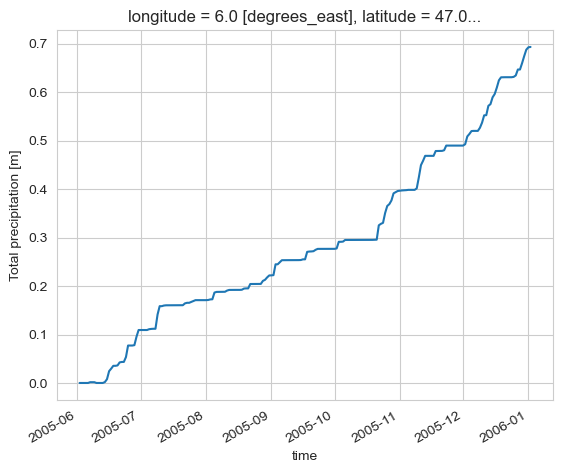

In [63]:
da.sel({"number":8, "longitude":6, "latitude": 47}).plot()

C:\Users\sb123\.conda\envs\Thesis2\lib\site-packages\xarray\coding\cftime_offsets.py:1134: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(


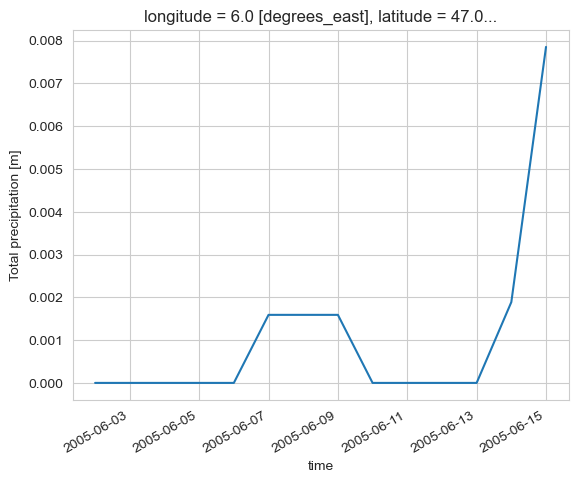

In [67]:
da.sel({"time": xr.date_range("2005-06-02", "2005-06-15"),"number":8, "longitude":6, "latitude": 47}).plot()

This is accumulated total precipitation. Weird jump up by ~1.5mm and then back to zero, before it apparently rained more.
Now I do check for the same file before the cropping was applied to see if these jumps also exist in the raw dataset.

In [110]:
da = xr.open_dataset(r"D:\Massendaten\ECMWF\SEAS5_Global\system_5_seasonal-monthly-single-levels_2005_06_total_precipitation.nc").sel({"latitude":slice(55,47), "longitude":slice(5,15)})["tp"]
diff2 = xr.concat([da.isel(time = 0), da.diff(dim="time")], dim="time")
diff2 *= 1_000
diff2.min().values

array(-1.59049034)

The issue persists... hence likely issue in raw data from CDS. now I check an arbitrary file where smaller negative values appear.

In [111]:
da = xr.open_dataset(r"D:\Massendaten\ECMWF\SEAS5_Global\system_5_seasonal-monthly-single-levels_2005_07_total_precipitation.nc").sel({"latitude":slice(55,47), "longitude":slice(5,15)})["tp"]
diff3 = xr.concat([da.isel(time = 0), da.diff(dim="time")], dim="time")
diff3 *= 1_000
# diff3
min = diff3.min().values
print(min)
print(f"{np.count_nonzero(diff3.stack(stacked_dim= [...]).values == min)} occurences of the identical min value in the forward diff - strange!")

-0.08749961853027344
336 occurences of the identical min value in the forward diff - strange!


## Question 2 Willi:
* Any idea if this is plausible with forecast data? Why would such a long float appear identically more than 300 times?!

In [109]:
# Redownloading this file to check if the issue is in the raw data:
months = ["06"]
path = r"D:\Massendaten\ECMWF\SEAS5_Global\Issue"

download_seasonal(2005, 2005, path, months=months)

2023-02-08 17:48:31,695 INFO Checking if system_5_seasonal-monthly-single-levels_2005_06_total_precipitation.nc already exists 

2023-02-08 17:48:31,697 INFO system_5_seasonal-monthly-single-levels_2005_06_total_precipitation.nc not found, trying to download file!
2023-02-08 17:48:31,739 INFO Welcome to the CDS
2023-02-08 17:48:31,740 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-original-single-levels
2023-02-08 17:48:31,854 INFO Request is completed
2023-02-08 17:48:31,855 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data9/adaptor.mars.external-1675874884.6165965-1160-6-6a109bf7-88f1-43bf-9239-af34d1e1061c.nc to D:\Massendaten\ECMWF\SEAS5_Global\Issue\system_5_seasonal-monthly-single-levels_2005_06_total_precipitation.nc (668M)
2023-02-08 17:50:48,720 INFO Download rate 4.9M/s  
2023-02-08 17:50:49,127 INFO Successfully downloaded system_5_seasonal-monthly-single-levels_2005_06_total_precipitation.nc

In [2]:
da = xr.open_dataset(r"D:\Massendaten\ECMWF\SEAS5_Global\Issue\system_5_seasonal-monthly-single-levels_2005_06_total_precipitation.nc").sel({"latitude":slice(55,47), "longitude":slice(5,15)})["tp"]
diff4 = xr.concat([da.isel(time = 0), da.diff(dim="time")], dim="time")
diff4 *= 1_000
min = diff4.min().values
print(min)

-1.5904903411865234


Jup, this issue seems to be in the raw data.
<br>
Found [this](https://confluence.ecmwf.int/display/UDOC/Why+are+there+sometimes+small+negative+precipitation+accumulations+-+ecCodes+GRIB+FAQ) hint. Testing if the absolute values of the error (i.e. negative increments) increase on average with lead time. This would support the justification provided in the weblink.

In [2]:
error_max = []
for file in tqdm(list(Path(r"D:\Massendaten\ECMWF\SEAS5_Global").glob("*precipitation.nc"))):
    errors = []
    da = xr.open_dataset(file).sel({"latitude":slice(55,47), "longitude":slice(5,15)})["tp"]
    da = xr.concat([da.isel(time = 0), da.diff(dim="time")], dim="time")
    da *= 1_000
    for lead in da.time.values:
        errors.append(abs(da.sel(time=lead).min().values))
    error_max.append(errors)
error_max_arr = np.array(error_max).transpose()

100%|██████████| 276/276 [10:56<00:00,  2.38s/it]


In [17]:
errs = pd.DataFrame(error_max_arr, index=range(1,216))
errs.index.rename("Lead", inplace=True)

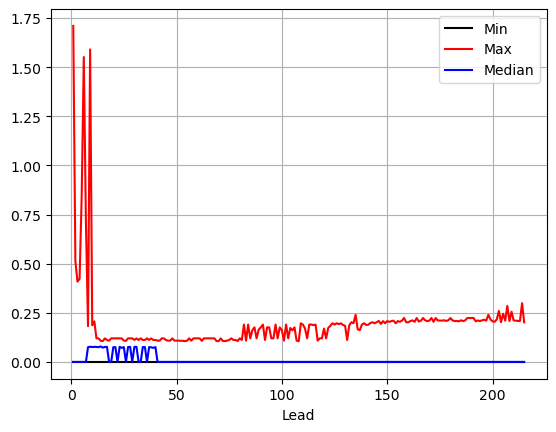

In [27]:
# plot the statistics of this min value over lead time for all forecast files
fig, ax = plt.subplots()
errs.quantile(q=0, axis=1).plot(ax=ax, label="Min", c="k")
errs.quantile(q=1, axis=1).plot(ax=ax, label="Max", c="r")
errs.quantile(q=.5, axis=1).plot(ax=ax, label="Median", c="b")
ax.legend()
ax.grid()